# Computing third-order shear statistics on a shape catalog

In this notebooks we compute the third-order shear correlation functions on a realistic shape catalog and transform them to the third-order aperture statistics.

In [1]:
from astropy.table import Table
import numpy as np
from matplotlib import pyplot as plt

import orpheus

## Obtaining a realistic mock shape catalog

We will run this notebook using a mocks shape catalog from the SLICS ensemble. First, let us download this catalog and read in its contents.

**Note:** If you want to run the notebook yourself, you need to update the `savepath_SLICS` variable.

In [2]:
path_to_SLICS = "http://cuillin.roe.ac.uk/~jharno/SLICS/MockProducts/KiDS450/GalCatalog_LOS1.fits"
savepath_SLICS = "/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/"

In [3]:
!wget {path_to_SLICS} -P {savepath_SLICS}

--2024-06-18 21:37:12--  http://cuillin.roe.ac.uk/~jharno/SLICS/MockProducts/KiDS450/GalCatalog_LOS1.fits
Resolving cuillin.roe.ac.uk (cuillin.roe.ac.uk)... 129.215.175.32
Connecting to cuillin.roe.ac.uk (cuillin.roe.ac.uk)|129.215.175.32|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196545600 (187M) [image/fits]
Saving to: ‘/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/GalCatalog_LOS1.fits.3’

GalCatalog_LOS1.fit 100%[===================>] 187,44M  43,9MB/s    in 4,2s    

2024-06-18 21:37:16 (44,1 MB/s) - ‘/vol/euclidraid4/data/lporth/HigherOrderLensing/Mocks/SLICS_KiDS450/GalCatalog_LOS1.fits.3’ saved [196545600/196545600]



In [4]:
slicscat = Table.read(savepath_SLICS)
print(slicscat.keys())

['x_arcmin', 'y_arcmin', 'z_spectroscopic', 'z_photometric', 'shear1', 'shear2', 'eps_obs1', 'eps_obs2']


## Initialize the catalog instance

As we are dealing with a ellipticity catalog, we need to use the `SpinTracerCatalog` class and set the value of `spin` to two.

In [5]:
shapecat = orpheus.SpinTracerCatalog(spin=2,
                                     pos1=slicscat["x_arcmin"],
                                     pos2=slicscat["y_arcmin"],
                                     tracer_1=slicscat["shear1"],
                                     tracer_2=slicscat["shear2"])

In [6]:
print("Number of galaxies:%i --> effective nbar: %.3f/arcmin^2 on %.2f deg^2"%(
    shapecat.ngal, shapecat.ngal/(shapecat.len1*shapecat.len2), shapecat.len1*shapecat.len2/3600.))

Number of galaxies:3070801 --> effective nbar: 8.530/arcmin^2 on 100.00 deg^2


## Computation of the shear 3pcf

For computing the natural components of the third-order shear correlation functions we need to invoke the `GGGCorrelation` class. In principle, it is only required to define a binning for the 3pcf (given my the range of the bins and the number of bins).

**Notes**

* Instead of the number of bins you can also specify the logarithmic bin-width `binsize`. However, the final value of `binsize` might differ slightly from the provided one as we fix the values for the binning range and then choose the largest possible value of `binsize` that is smaller or equal to the input value for `binsize`.

* If no further parameters are passed, the default setup chooses the some accelerations of the discrete multipole estimator renders fairly accurate results for the 3pcf itself and percent-level accuracy for the third-order aperture statistics. In case you want a different setup than the default results you can change the parameters of the parent `BinnedNPCF` class.

In [7]:
orpheus.GGGCorrelation.__init__

<function orpheus.npcf.GGGCorrelation.__init__(self, n_cfs, min_sep, max_sep, **kwargs)>

In [8]:
orpheus.BinnedNPCF.__init__

<function orpheus.npcf.BinnedNPCF.__init__(self, order, spins, n_cfs, min_sep, max_sep, nbinsr=None, binsize=None, nbinsphi=100, nmaxs=30, method='DoubleTree', multicountcorr=True, diagrenorm=False, shuffle_pix=1, tree_resos=[0, 0.25, 0.5, 1.0, 2.0], tree_redges=None, rmin_pixsize=20, resoshift_leafs=0, minresoind_leaf=None, maxresoind_leaf=None, nthreads=16)>

In [9]:
min_sep = 0.5
max_sep = 150.
binsize = 0.1
nthreads=64

In [10]:
threepcf = orpheus.GGGCorrelation(n_cfs=4,
                                  min_sep=min_sep, max_sep=max_sep,binsize=binsize,
                                  nthreads=nthreads)

<CDLL '/vol/euclidraid4/data/lporth/HigherOrderLensing/Estimator/orpheus/orpheus/src/discrete.so', handle 4db5f90 at 0x7f1c02a7c680>


In [11]:
%%time
threepcf.process(shapecat)

Done 87.84 per center cent17 per cent 58.75 per centCPU times: user 4h 56min 55s, sys: 15 s, total: 4h 57min 10s
Wall time: 6min 4s


Once processed, the instance of `GGGCorrelation` contains the multipole components of the third-order shear correlators $\Upsilon_{\mu,n}$, as well as their nonrmalizations $\mathcal{N}_n$ in their multipole basis. If required, we can use the `multiples2npcf` method to transform the to the real-space basis, in which they become the more well-known natural components $\Gamma_{\mu}$ of the shear 3PCF (Schneider 2003).

In [12]:
%%time
threepcf.multipoles2npcf()

CPU times: user 401 ms, sys: 6 µs, total: 401 ms
Wall time: 399 ms


Unless otherwise specified, the projection of the shear is not altered - hence it is given in the projection favoured by the multipole estimator, which in `orpheus` is dubbed the `X`-projection. To transform it the the `centroid` projection we can use the `projectnpcf` methods. <br>
The current projection can always be accessed by the `projection` attribute.

In [13]:
%%time
print("Current 3PCF projection: %s"%threepcf.projection)
threepcf.projectnpcf("Centroid")
print("Current 3PCF projection: %s"%threepcf.projection)

Current 3PCF projection: X
Current 3PCF projection: Centroid
CPU times: user 430 ms, sys: 7.99 ms, total: 438 ms
Wall time: 435 ms


## Computation of the aperture mass

The integral transormation between the shear 3PCF and the third-order aperture statistics can be done by calling the `GGGCorrelation.computeMap3` method.

**Notes**

* In case you are only interested in obtaining the third-order aperture statistics, you can also directly call this method right after processing the shape catalog.

* One should only trust the third-order aperture statistics for radii $R\in[\alpha\,\theta_{\rm min}, \beta\,\theta_{\rm max}]$, where $\alpha\approx 0.2$  and $\beta \approx 8$. In the plot below this range is indicated by the dashed vertical lines.

* Furthermore, the binning should be sufficiently fine, i.e. the value of the `GGGCorrelation.binsize` attribute should be less than `0.1` for an accuracy of about one per cent.

In [14]:
mapradii = np.geomspace(1,30,20)

In [15]:
%%time
map3 = threepcf.computeMap3(mapradii)

CPU times: user 5.66 s, sys: 6.8 s, total: 12.5 s
Wall time: 4.03 s


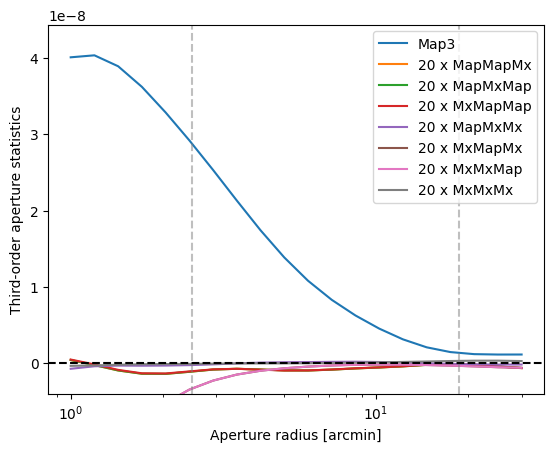

In [16]:
scaleB = 20 # Rescale the B-modes for better visualization
scaleP = 20 # Rescale the parity-violating-modes for better visualization
plt.semilogx(mapradii,map3[0,0].real, label="Map3")
plt.semilogx(mapradii,scaleP*map3[1,0].real, label="%i x MapMapMx"%scaleP)
plt.semilogx(mapradii,scaleP*map3[2,0].real, label="%i x MapMxMap"%scaleP)
plt.semilogx(mapradii,scaleP*map3[3,0].real, label="%i x MxMapMap"%scaleP)
plt.semilogx(mapradii,scaleB*map3[4,0].real, label="%i x MapMxMx"%scaleB)
plt.semilogx(mapradii,scaleB*map3[5,0].real, label="%i x MxMapMx"%scaleB)
plt.semilogx(mapradii,scaleB*map3[6,0].real, label="%i x MxMxMap"%scaleB)
plt.semilogx(mapradii,scaleP*map3[7,0].real, label="%i x MxMxMx"%scaleP)
plt.axvline(x=5*threepcf.min_sep, color="grey",alpha=0.5,ls="--")
plt.axvline(x=0.125*threepcf.max_sep, color="grey",alpha=0.5,ls="--")
plt.axhline(y=0,color="black",ls="--")
plt.xlabel("Aperture radius [arcmin]")
plt.ylabel("Third-order aperture statistics")
plt.ylim(-.1*np.max(map3[0,0].real),1.1*np.max(map3[0,0].real))
plt.legend()